### Importing the dataset

In [6]:
import os
import struct
import numpy as np
from matplotlib import pyplot as plt 

In [7]:
def read(dataset = "training", path = "."):
    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        print("dataset must be 'testing' or 'training'")

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        _, __, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    get_img = lambda idx: (lbl[idx], img[idx])

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_img(i)

def show(image):
    from matplotlib import pyplot
    import matplotlib as mpl
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.gray)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()

In [8]:
train = read('training', 'MNIST'); test = read('testing', 'MNIST')

In [9]:
img_train = []
lbl_train = []
img_test = []
lbl_test = []
for temp in train:
    img_train.append(temp[1])
    lbl_train.append(temp[0])

for temp in test:
    img_test.append(temp[1])
    lbl_test.append(temp[0])

img_train = np.array(img_train)
lbl_train = np.array(lbl_train)
img_test = np.array(img_test)
lbl_test = np.array(lbl_test)

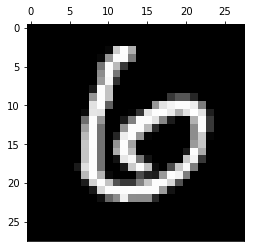

6


In [10]:
show(img_test[11])
print(lbl_test[11])

# The Multilayer feedforward neural network
This section contains the code for MLFFNN

In [11]:
class Relu:
   
    @staticmethod
    def activation(z):
        print(z)
        z[z < 0] = 0
        return z
    @staticmethod
    def derivative(z):
        z[z < 0] = 0
        z[z > 0] = 1
        return z
        
class Sigmoid:
    @staticmethod
    def activation(z):
        return 1 / (1 + np.exp(-z))
    @staticmethod
    def derivative(z):
        return Sigmoid.activation(z) * (1 - Sigmoid.activation(z))
    
class MSE:
    def __init__(self, activation_fn=None):
        self.activation_fn = activation_fn
            
    def activation(self, z):
        return self.activation_fn.activation(z)

    @staticmethod
    def loss(y_true, y_pred):
        return np.mean((y_pred - y_true)**2)

    @staticmethod
    def derivative(y_true, y_pred):
        return y_pred - y_true

    def delta(self, y_true, y_pred):
        return self.derivative(y_true, y_pred) * self.activation_fn.derivative(y_pred)
    

class NeuralNetwork(object):
    def __init__(self, dimensions, activation_fns):
        self.n_layers = len(dimensions)
        self.loss = None
        self.learning_rate = None
        self.weights = {}
        self.bais = {}
        self.activations = {}
        for i in range(self.n_layers - 1):
            self.weights[i + 1] = np.random.randn(dimensions[i], dimensions[i + 1]) / np.sqrt(dimensions[i])
            self.bais[i + 1] = np.zeros(dimensions[i + 1])
            self.activations[i + 2] = activations_fns[i]
            
    def feed_forward(self, x):
        z = {}
        activated = {1: x}
        for i in range(1, self.n_layers):
            z[i + 1] = np.dot(a[i], self.w[i]) + self.b[i]
            activated[i + 1] = self.activations[i + 1].activation(z[i + 1])
        return z, activated
    
    def back_propagation(self, z, a, y_true):
        delta = self.loss.delta(y_true, a[self.n_layers])
        partial_derivative = np.dot(a[self.n_layers - 1].T, delta)

        update_params = {
            self.n_layers - 1: (partial_derivative, delta)
        }

        for i in reversed(range(2, self.n_layers)):
            delta = np.dot(delta, self.weights[i].T) * self.activations[i].derivative(z[i])
            partial_derivative = np.dot(a[i - 1].T, delta)
            update_params[i - 1] = (partial_derivative, delta)

        for key, values in update_params.items():
            self.update_fn(key, values[0], values[1])
        
    def update_fn(self, key, partial_derivative, delta):
        self.weights[key] -= self.learning_rate * partial_derivative
        self.bais[key] -= self.learning_rate * np.mean(delta, 0)

    def learn(x, y_true, loss, epochs, batch_size, learning_rate):
        self.loss = loss(self.activations[self.n_layers])
        self.learning_rate = learning_rate
        for i in range(epochs):
            seed = np.arange(x.shape[0])
            np.random.shuffle(seed)
            x_ = x[seed]
            y_ = y_true[seed]
            for j in range(x.shape[0] // batch_size):
                k = j * batch_size
                l = (j + 1) * batch_size
                z, a = self.feed_forward(x_[k:l])
                self.back_propagation(z, a, y_[k:l])

            if (i + 1) % 10 == 0:
                _, a = self.feed_forward(x)
                print("Loss:", self.loss.loss(y_true, a[self.n_layers]))
    
    def predict(self, x):
        _, a = self._feed_forward(x)
        return a[self.n_layers]



In [22]:
from sklearn.model_selection import KFold
X = img_train
y = lbl_train
kf = KFold(n_splits=5)
for train, test in kf.split(X):
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]